In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from database import *


/usr/local/lib/python3.5/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
batch_size = 1

mr = ModelReader(batch_size)

Connecting to the PostgreSQL database...


In [3]:
batch = mr.getGraspBatch()

one_grasp = batch[0]
params = config(section='data')

scale, grasp_rescale, model_path = mr.getModelInfo(one_grasp["scaled_model_id"])
#model_file = open(params['model_dir'] + model_path)
from pyntcloud import PyntCloud
m = PyntCloud.from_file(params['model_dir'] + model_path)

#pt_cld = m.points.values
pt_cld = m.get_sample("mesh_random", n=10000, rgb=False, normals=False).values
contacts = np.array(one_grasp['grasp_contacts']).reshape(-1, 3)

/usr/local/lib/python3.5/dist-packages/pyntcloud/core_class.py:567: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v1 = points[[self.mesh["v1"]]]
/usr/local/lib/python3.5/dist-packages/pyntcloud/core_class.py:568: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v2 = points[[self.mesh["v2"]]]
/usr/local/lib/python3.5/dist-packages/pyntcloud/core_class.py:569: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array ind

In [4]:
# grasp_grasp_joints and grasp_grasp_position contain the information necessary to recreate the grasp.


#  grasp_grasp_joints    
#     Joint angles for the grasp.
    
#  grasp_grasp_position  
# World coordinates and quaternion representing the position and orientation of the hand (X, Y, Z, qW, qX, qY, qZ) for the grasp.

    
# BARRETT_RUBBER  |       1
#  BARRETT_WOOD    |       2
#  HUMAN           |       4 (what we're doing, 20 dof)
#  WILLOW_GRIPPER  |       5
#  BARRETT_PLASTIC |       3
#  MC_GRIP         |       6
# (6 rows)

            


In [5]:
a = np.array(one_grasp['grasp_grasp_joints'])
a[1:] *= 180./np.pi
#a[1:].reshape(5, -1)
#first one seems to be always 5 (confirmed, probably number of fingers)
#need to know start of each finger and length of each digit though


In [6]:
one_grasp['grasp_grasp_position']
#first one always 0? (0, x, y, z, then 4d quaternion)
#first one 0 confirmed (meaning???)

[0.0, -25.3141, 0.298803, 238.308, 0.117176, 0.231929, 0.033722, 0.96506]

In [239]:
import math

def rotation_matrix(angle, direction, point=None):
    sina = math.sin(angle)
    cosa = math.cos(angle)
#     direction = unit_vector(direction[:3])
    # rotation matrix around unit vector
    R = np.diag([cosa, cosa, cosa])
    R += np.outer(direction, direction) * (1.0 - cosa)
    direction *= sina
    R += np.array([[ 0.0,         -direction[2],  direction[1]],
                      [ direction[2], 0.0,          -direction[0]],
                      [-direction[1], direction[0],  0.0]])
    return R
#     M = np.identity(4)
#     M[:3, :3] = R
#     if point is not None:
#         # rotation not around origin
#         point = np.array(point[:3], dtype=np.float64, copy=False)
#         M[:3, 3] = point - np.dot(R, point)
    return M

def genR(x=0, y=0, z=0):
    Rx = np.eye(3)
    Rx[1, 1] = np.cos(x)
    Rx[1, 2] = -np.sin(x)
    Rx[2, 1] = np.sin(x)
    Rx[2, 2] = np.cos(x)
    
    Ry = np.eye(3)
    Ry[0, 0] = np.cos(x)
    Ry[0, 2] = np.sin(x)
    Ry[2, 0] = -np.sin(x)
    Ry[2, 2] = np.cos(x)
    
    Rz = np.eye(3)
    Rz[0, 0] = np.cos(x)
    Rz[0, 1] = -np.sin(x)
    Rz[1, 0] = np.sin(x)
    Rz[1, 1] = np.cos(x)
    
    R = Rz @ Ry @ Rx
    return R

# print(rotation_matrix(- np.pi / 2., np.array([1.,0.,0.]) ) @ np.array([-40.0,0,0]).T)
# print(genR(- np.pi / 2.) @ np.array([-40.0,0,0]).T)

def quat_to_rot(q):
    # ref: https://www.lfd.uci.edu/~gohlke/code/transformations.py.html
    n = np.dot(q, q)
    q *= math.sqrt(2.0 / n)
    q = np.outer(q, q)
    return np.array([
        [1.0-q[2, 2]-q[3, 3],     q[1, 2]-q[3, 0],     q[1, 3]+q[2, 0]],
        [    q[1, 2]+q[3, 0], 1.0-q[1, 1]-q[3, 3],     q[2, 3]-q[1, 0]],
        [    q[1, 3]-q[2, 0],     q[2, 3]+q[1, 0], 1.0-q[1, 1]-q[2, 2]]])

[[ 1.000000e+00  0.000000e+00  0.000000e+00]
 [ 0.000000e+00  6.123234e-17  1.000000e+00]
 [ 0.000000e+00 -1.000000e+00  6.123234e-17]]
[-40.   0.   0.]
[-1.49975978e-31  2.44929360e-15 -4.00000000e+01]


In [335]:
class Joint:
    
    def __init__(self, offset, R0, dof, parent=None):
        self.dof = dof
        self.R = R0
        self.t =  np.array([offset]).T
        self.parent = parent
        self.child = None
        self.pos = np.zeros(3)
        self.M = np.eye(3)
    
    def setDofs(self, dofs):
        self.dof = dofs[0]                
        if self.child != None:
            self.child.setDofs(dofs[1:]) 
    
    def updatePositions(self, transform, translate):
        
        self.pos = translate + transform @ self.t
        print(self.dof)
        self.M = transform  @ self.R# @ genR(x=self.dof) #rotation_matrix(self.dof, np.array([1.,0.,0.]))  
                
        if self.child != None:
           self.child.updatePositions(self.M, self.pos) 

class UniversalJoint(Joint):
    def __init__(self, offset, R0, dof1, dof2, parent=None):
        super(UniversalJoint, self).__init__(offset, R0, dof1, parent)
        self.dof1 = dof1
        self.dof2 = dof2
    
    def setDofs(self, dofs):
        self.dof1 = dofs[0]
        self.dof2 = dofs[1]
         
        if self.child != None:
            self.child.setDofs(dofs[2:])
            
    def updatePositions(self, transform, translate):

        self.pos = translate + transform @ self.t

        self.M = transform  @ self.R #@ rotation_matrix(self.dof2, np.array([0.,0.,1.]))  #genR(y=self.dof1, x=self.dof2)
        if self.child != None:
            self.child.updatePositions(self.M, self.pos)
        

class HumanHand:
    """
    Each finger is a list of joints. 
    """
    NUM_JOINTS = 20
    NUM_FINGERS = 5
    JOINTS_PER_FINGER = 4
    
    def __init__(self, hand_pos, hand_orientation):
        self.dofs = np.zeros(self.NUM_JOINTS)
        self.root_translation = hand_pos
        self.root_orientiation = hand_orientation
        self.fingers = []

    def addFinger(self, offsets, R0, dof0):
        j0 = UniversalJoint(offsets[0], R0, dof0[0], dof0[1])
        j1 = Joint(offsets[1], np.eye(3), dof0[2], j0)
        j2 = Joint(offsets[2], np.eye(3), dof0[3], j1)
        j3 = Joint(offsets[3], np.eye(3), 0, j2)
        j0.child = j1
        j1.child = j2
        j2.child = j3
        
        self.fingers.append(j0)
        
    def updateDofs(self, dofs):
        for i, joint in enumerate(self.fingers):
            b = i*JOINTS_PER_FINGER
            e = i*JOINTS_PER_FINGER+JOINTS_PER_FINGER
            joint.setDofs(dofs[b:e]) 
    
    def updateJointPositions(self):
        # compute position for each joint
        for joint in self.fingers:
            #TODO replace with quat
            joint.updatePositions(np.eye(3), self.root_translation)
        
    def getJointPositions(self):
        print("Getting joint positions")
        hand_pts = list()
        
        hand_pts.append(self.root_translation)
        for joint in self.fingers:
#             hand_pts.append(joint.pos)
            idx = 0
            next_joint = joint
            while next_joint != None:
                hand_pts.append(next_joint.pos)
                next_joint = next_joint.child
                idx+=1
        return np.concatenate(hand_pts, axis=1).T


0
0
0
0
0
0
0
0
0
0
0
0
0.08726646259971647
1.4835298641951802
0
Getting joint positions


<IPython.core.display.Javascript object>


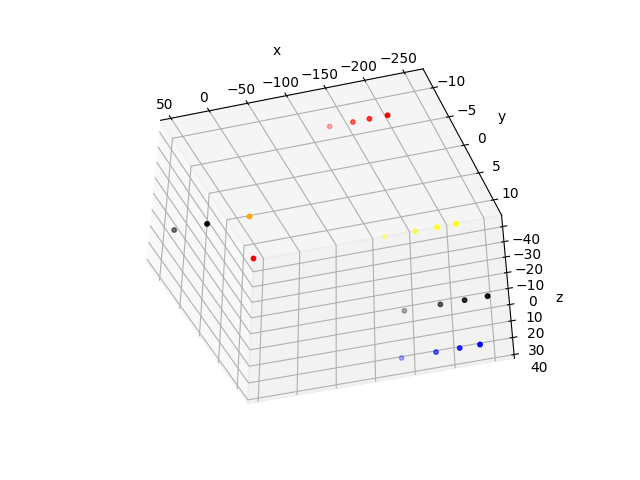

In [349]:
start = np.array([[0,0,0]]).T #np.array(one_grasp['grasp_grasp_position'])[np.newaxis, 1:4].T
quat = np.array(one_grasp['grasp_grasp_position'])[4:8]
orientation = quat_to_rot(quat)

RotX = rotation_matrix(-np.pi/2., np.array([1.,0.,0.])) 
RotThumb = np.array([-0.1486, -0.9003, 0.4089, 0.2665, 0.3618, 0.8933, -0.9522, 0.2418, 0.1862]).reshape(3, 3)
# Offsets w.r.t parent coordinate frames with every 4 offsets corresponding to a finger
# The first two joints per finger are assigned to a universal joint, so that's why one offset is always 0
joint_offsets = [[-140.0599, 11.2048, 36.4156],  [-43.19, 0.0, 0.0], [-29.56, 0.0, 0.0], [-25.35, 0.0, 0.0], \
                 [-145.6623, 11.2048, 8.4036],   [-46.20, 0.0, 0.0], [-30.99, 0.0, 0.0], [-29.20, 0.0, 0.0], \
                 [-145.6623, 5.6025, -19.6084],  [-39.12, 0.0, 0.0], [-28.31, 0.0, 0.0], [-24.48, 0.0, 0.0], \
                 [-134.4575, -8.4035, -42.0180], [-29.91, 0.0, 0.0], [-21.10, 0.0, 0.0], [-23.16, 0.0, 0.0], \
                 [-50.6241, -11.5082, 18.9317],  [52.1193, 0.0, 0.0], [40.7638, 0.0, 0.0], [0, 0.0, 0.0]]

# Joints may have have constant additions to their joint aingle dof
# The thumb values in human hand xml file has angle offsets for the thumb joints
joint_angle_offsets = [0, 0, 0, 0, \
                       0, 0, 0, 0, \
                       0, 0, 0, 0, \
                       0, 0, 0, 0, \
                       0, deg2rad*49.5, deg2rad*5.0, deg2rad*85.0]
# RotX = np.eye(3)
RotThumb = np.eye(3)
h = HumanHand(start, orientation)
h.addFinger(joint_offsets[0:4], RotX, joint_angle_offsets[0:4])         # fore finger
h.addFinger(joint_offsets[4:8], RotX, joint_angle_offsets[4:8])         # middle
h.addFinger(joint_offsets[8:12], RotX, joint_angle_offsets[8:12])       # ring
h.addFinger(joint_offsets[12:16], RotX, joint_angle_offsets[12:16])     # pinky
h.addFinger(joint_offsets[16:20], RotThumb, joint_angle_offsets[16:20]) # thumb

h.updateJointPositions()
hand_pts = h.getJointPositions()


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(hand_pts[0, 0], hand_pts[0, 1], hand_pts[0, 2], zdir='z', c= 'red', s=10)
# ax.scatter(hand_pts[1:, 0], hand_pts[1:, 1], hand_pts[1:, 2], zdir='z', c= 'blue', s=10)

ax.scatter(hand_pts[1:5, 0], hand_pts[1:5, 1], hand_pts[1:5, 2], zdir='z', c= 'blue', s=10)
ax.scatter(hand_pts[5:9, 0], hand_pts[5:9, 1], hand_pts[5:9, 2], zdir='z', c= 'black', s=10)
ax.scatter(hand_pts[9:13, 0], hand_pts[9:13, 1], hand_pts[9:13, 2], zdir='z', c= 'yellow', s=10)
ax.scatter(hand_pts[13:17, 0], hand_pts[13:17, 1], hand_pts[13:17, 2], zdir='z', c= 'red', s=10)
ax.scatter(hand_pts[17:18, 0], hand_pts[17:18, 1], hand_pts[17:18, 2], zdir='z', c= 'orange', s=10)
ax.scatter(hand_pts[18:21, 0], hand_pts[18:21, 1], hand_pts[18:21, 2], zdir='z', c= 'black', s=10)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');
plt.show()

<IPython.core.display.Javascript object>


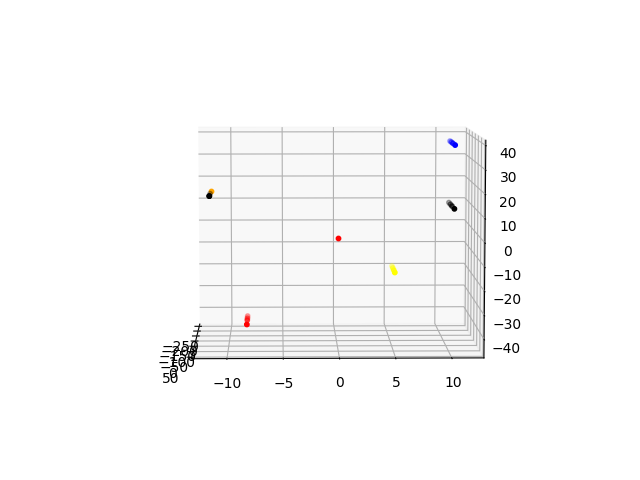

In [277]:
# start = np.array(one_grasp['grasp_grasp_position'])[np.newaxis, 1:4].T
# start = np.array([0, 0, 0])[np.newaxis, 0:4].T

# quat = np.array(one_grasp['grasp_grasp_position'])[4:8]
# orientation = quat_to_rot(quat)
# hand_pts = []

# deg2rad = np.pi / 180.

# Rx = genR(x=-90*deg2rad)
# Rx = rotation_matrix(-np.pi/2., np.array([1.,0.,0.])) 

# # Rx = np.eye(3)
# # Additional rotation transform for thumb
# Rt = np.array([-0.1486, -0.9003, 0.4089, 0.2665, 0.3618, 0.8933, -0.9522, 0.2418, 0.1862]).reshape(3, 3)

# # Offsets w.r.t parent coordinate frames with every 4 offsets corresponding to a finger
# # The first two joints per finger are assigned to a universal joint, so that's why one offset is always 0
# joint_offsets = [0, -43.19, -29.56, -25.35, \
#                  0, -46.20, -30.99, -29.20, \
#                  0, -39.12, -28.31, -24.48, \
#                  0, -29.91, -21.10, -23.16, \
#                  0, 52.1193, 40.7638, 0]

# # Joints may have have constant additions to their joint aingle dof
# # The thumb values in human hand xml file has angle offsets for the thumb joints
# joint_angle_offsets = [0, 0, 0, 0, \
#                        0, 0, 0, 0, \
#                        0, 0, 0, 0, \
#                        0, 0, 0, 0, \
#                        0, deg2rad*49.5, deg2rad*5.0, deg2rad*85.0]


In [226]:

    
np.array([-140.0599, 11.2048, 36.4156]).shape


(3,)

In [ ]:
#  <chain>
#         <transform>
#             <translation>-140.0599 11.2048 36.4156</translation>
#             <rotation>-90 x</rotation>
#         </transform>
#         <joint type="Revolute">
#             <theta>d0</theta>
#             <d>0</d>
#             <a>0</a>
#             <alpha>90</alpha>
#             <minValue>-20</minValue>
#             <maxValue>20</maxValue>
#             <viscousFriction>5.0e+7</viscousFriction>
#         </joint>
#         <joint type="Revolute">
#             <theta>d1</theta>
#             <d>0</d>
#             <a>-43.19</a>
#             <alpha>0</alpha>
#             <minValue>-10</minValue>
#             <maxValue>90</maxValue>
#             <viscousFriction>5.0e+7</viscousFriction>
#         </joint>
#         <joint type="Revolute">
#             <theta>d2</theta>
#             <d>0</d>
#             <a>-29.56</a>
#             <alpha>0</alpha>
#             <minValue>-10</minValue>
#             <maxValue>90</maxValue>
#             <viscousFriction>5.0e+7</viscousFriction>
#         </joint>
#         <joint type="Revolute">
#             <theta>d3</theta>
#             <d>0</d>
#             <a>-25.35</a>
#             <alpha>0</alpha>
#             <minValue>-10</minValue>
#             <maxValue>90</maxValue>
#             <viscousFriction>5.0e+7</viscousFriction>
#         </joint>
#         <link dynamicJointType="Universal">index1.xml</link>
#         <link dynamicJointType="Revolute">index2.xml</link>
#         <link dynamicJointType="Revolute">index3.xml</link>
#     </chain>
#     <chain>
#         <transform>
#             <translation>-145.6623 11.2048 8.4036</translation>
#             <rotation>-90 x</rotation>
#         </transform>
#         <joint type="Revolute">
#             <theta>d4</theta>
#             <d>0</d>
#             <a>0</a>
#             <alpha>90</alpha>
#             <minValue>-10</minValue>
#             <maxValue>10</maxValue>
#             <viscousFriction>5.0e+7</viscousFriction>
#         </joint>
#         <joint type="Revolute">
#             <theta>d5</theta>
#             <d>0</d>
#             <a>-46.20</a>
#             <alpha>0</alpha>
#             <minValue>-10</minValue>
#             <maxValue>90</maxValue>
#             <viscousFriction>5.0e+7</viscousFriction>
#         </joint>
#         <joint type="Revolute">
#             <theta>d6</theta>
#             <d>0</d>
#             <a>-30.99</a>
#             <alpha>0</alpha>
#             <minValue>-10</minValue>
#             <maxValue>90</maxValue>
#             <viscousFriction>5.0e+7</viscousFriction>
#         </joint>
#         <joint type="Revolute">
#             <theta>d7</theta>
#             <d>0</d>
#             <a>-29.20</a>
#             <alpha>0</alpha>
#             <minValue>-10</minValue>
#             <maxValue>90</maxValue>
#             <viscousFriction>5.0e+7</viscousFriction>
#         </joint>
#         <link dynamicJointType="Universal">mid1.xml</link>
#         <link dynamicJointType="Revolute">mid2.xml</link>
#         <link dynamicJointType="Revolute">mid3.xml</link>
#     </chain>
#     <chain>
#         <transform>
#             <translation>-145.6623 5.6025 -19.6084</translation>
#             <rotation>-90 x</rotation>
#         </transform>
#         <joint type="Revolute">
#             <theta>d8</theta>
#             <d>0</d>
#             <a>0</a>
#             <alpha>90</alpha>
#             <minValue>-20</minValue>
#             <maxValue>20</maxValue>
#             <viscousFriction>5.0e+7</viscousFriction>
#         </joint>
#         <joint type="Revolute">
#             <theta>d9</theta>
#             <d>0</d>
#             <a>-39.12</a>
#             <alpha>0</alpha>
#             <minValue>-10</minValue>
#             <maxValue>90</maxValue>
#             <viscousFriction>5.0e+7</viscousFriction>
#         </joint>
#         <joint type="Revolute">
#             <theta>d10</theta>
#             <d>0</d>
#             <a>-28.31</a>
#             <alpha>0</alpha>
#             <minValue>-10</minValue>
#             <maxValue>90</maxValue>
#             <viscousFriction>5.0e+7</viscousFriction>
#         </joint>
#         <joint type="Revolute">
#             <theta>d11</theta>
#             <d>0</d>
#             <a>-24.48</a>
#             <alpha>0</alpha>
#             <minValue>-10</minValue>
#             <maxValue>90</maxValue>
#             <viscousFriction>5.0e+7</viscousFriction>
#         </joint>
#         <link dynamicJointType="Universal">ring1.xml</link>
#         <link dynamicJointType="Revolute">ring2.xml</link>
#         <link dynamicJointType="Revolute">ring3.xml</link>
#     </chain>
#     <chain>
#         <transform>
#             <translation>-134.4575 -8.4035 -42.0180</translation>
#             <rotation>-90 x</rotation>
#         </transform>
#         <joint type="Revolute">
#             <theta>d12</theta>
#             <d>0</d>
#             <a>0</a>
#             <alpha>90</alpha>
#             <minValue>-30</minValue>
#             <maxValue>30</maxValue>
#             <viscousFriction>5.0e+7</viscousFriction>
#         </joint>
#         <joint type="Revolute">
#             <theta>d13</theta>
#             <d>0</d>
#             <a>-29.91</a>
#             <alpha>0</alpha>
#             <minValue>-10</minValue>
#             <maxValue>90</maxValue>
#             <viscousFriction>5.0e+7</viscousFriction>
#         </joint>
#         <joint type="Revolute">
#             <theta>d14</theta>
#             <d>0</d>
#             <a>-21.10</a>
#             <alpha>0</alpha>
#             <minValue>-10</minValue>
#             <maxValue>90</maxValue>
#             <viscousFriction>5.0e+7</viscousFriction>
#         </joint>
#         <joint type="Revolute">
#             <theta>d15</theta>
#             <d>0</d>
#             <a>-23.16</a>
#             <alpha>0</alpha>
#             <minValue>-10</minValue>
#             <maxValue>90</maxValue>
#             <viscousFriction>5.0e+7</viscousFriction>
#         </joint>
#         <link dynamicJointType="Universal">pinky1.xml</link>
#         <link dynamicJointType="Revolute">pinky2.xml</link>
#         <link dynamicJointType="Revolute">pinky3.xml</link>
#     </chain>
#     <chain>
#         <transform>
#             <translation>-50.6241 -11.5082 18.9317</translation>
#             <rotationMatrix>-0.1486 -0.9003 0.4089 0.2665 0.3618 0.8933 -0.9522 0.2418 0.1862</rotationMatrix>
#         </transform>
#         <joint type="Revolute">
#             <theta>d16</theta>
#             <d>0.0</d>
#             <a>0.0</a>
#             <alpha>90.0</alpha>
#             <minValue>-10</minValue>
#             <maxValue>70</maxValue>
#             <viscousFriction>5.0e+7</viscousFriction>
#         </joint>
#         <joint type="Revolute">
#             <theta>d17+49.5</theta>
#             <d>0.0</d>
#             <a>52.1193</a>
#             <alpha>44.0</alpha>
#             <minValue>-50</minValue>
#             <maxValue>25</maxValue>
#             <viscousFriction>5.0e+7</viscousFriction>
#         </joint>
#         <joint type="Revolute">
#             <theta>d18+5.0</theta>
#             <d>0.0</d>
#             <a>40.7638</a>
#             <alpha>0.0</alpha>
#             <minValue>0</minValue>
#             <maxValue>90</maxValue>
#             <viscousFriction>5.0e+7</viscousFriction>
#         </joint>
#         <joint type="Revolute">
#             <theta>d19+85.0</theta>
#             <d>0.0</d>
#             <a>0.0</a>
#             <alpha>90.0</alpha>
#             <minValue>0</minValue>
#             <maxValue>100</maxValue>
#             <viscousFriction>5.0e+7</viscousFriction>
#         </joint>
#         <link dynamicJointType="Universal">thumb1.xml</link>
#         <link dynamicJointType="Revolute">thumb2.xml</link>
#         <link dynamicJointType="Revolute">thumb3.xml</link>
#     </chain>

In [ ]:
#so we have the starting position (x, y, z), seems to correspond to grasp_rescale and regular rescaled point cloud
#we have orientation of hand
#we have angle of 4 joints for each finger (our hand only really has 3 joints finger though?)
#don't know length of each digit or default orientation (0 degree rotation) for each one



In [ ]:
print(scale, grasp_rescale)

In [ ]:
pt_cld *= grasp_rescale
#pt_cld *= scale

start = np.array(one_grasp['grasp_grasp_position'])[1:4]


In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pt_cld[:, 0], pt_cld[:, 1], pt_cld[:, 2], zdir='z', c= 'red', s=0.1)

#ax.scatter(start[0], start[1], start[2], zdir='z', c= 'black', s=10)

ax.scatter(contacts[:, 0], contacts[:, 1], contacts[:, 2], zdir='z', c= 'black', s=10)
plt.show()

In [ ]:
import open3d as o3
from open3d import JVisualizer


pcd = o3.PointCloud()
pcd.points = o3.Vector3dVector(pt_cld)

#o3.draw_geometries([pcd])
visualizer = JVisualizer()
visualizer.add_geometry(pcd)
visualizer.show()
#plt.show()

